<a href="https://colab.research.google.com/github/binhvd/Data-Analytics-3-Solutions/blob/main/7_Animal_Classification_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [4]:
!wget https://storage.googleapis.com/srh-dataset/animal-classification/animal.zip
!unzip -q animal.zip -d temp

--2023-05-24 10:12:12--  https://storage.googleapis.com/srh-dataset/animal-classification/animal.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘animal.zip’

animal.zip          100%[===================>] 543.16M  12.1MB/s    in 48s     

2023-05-24 10:13:02 (11.4 MB/s) - ‘animal.zip’ saved [569546721/569546721]



In [5]:
!mkdir -p data/dog
!mkdir -p data/cat
!cp temp/train/dog.* data/dog/
!cp temp/train/cat.* data/cat/

In [6]:
import os

dog_count = len(os.listdir("./data/dog"))
cat_count = len(os.listdir("./data/cat"))
print("Dog pictures: ", dog_count)
print("Cat pictures: ", cat_count)

Dog pictures:  12500
Cat pictures:  12500


In [7]:
# Not enough memory to train 227x227
IMAGE_WIDTH=170
IMAGE_HEIGHT=170
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=32

In [19]:
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

(train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


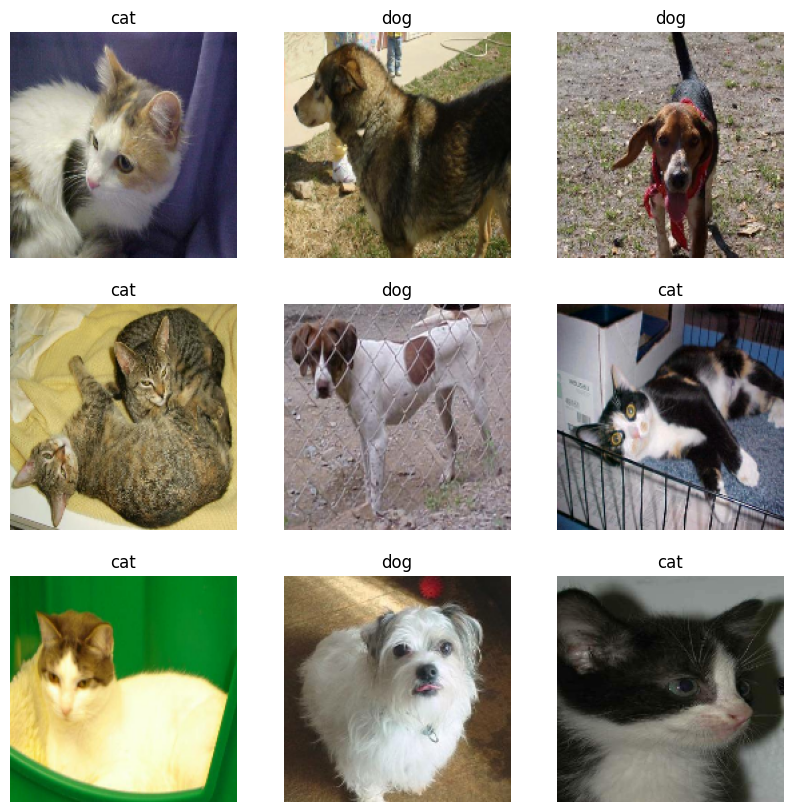

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [14]:
from tensorflow import keras
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = keras.models.Sequential([
    keras.layers.InputLayer((IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    keras.layers.Rescaling(1./255),  
    keras.layers.RandomZoom(.2),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(.2),
    keras.layers.RandomTranslation(.1, .1),

    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 170, 170, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 170, 170, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 170, 170, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 170, 170, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 170, 170, 3)      0         
 ranslation)                                                     
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 96)        3

In [15]:
epochs = 10

train = model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
625/625 [==============================] - 63s 75ms/step - loss: 1.1202 - accuracy: 0.5767 - val_loss: 0.7521 - val_accuracy: 0.5464 - lr: 1.0000e-04
Epoch 2/10
625/625 [==============================] - 23s 36ms/step - loss: 0.7117 - accuracy: 0.6244 - val_loss: 0.6309 - val_accuracy: 0.6440 - lr: 1.0000e-04
Epoch 3/10
625/625 [==============================] - 23s 36ms/step - loss: 0.6106 - accuracy: 0.6910 - val_loss: 0.5811 - val_accuracy: 0.6788 - lr: 1.0000e-04
Epoch 4/10
625/625 [==============================] - 23s 36ms/step - loss: 0.5596 - accuracy: 0.7258 - val_loss: 0.5492 - val_accuracy: 0.7266 - lr: 1.0000e-04
Epoch 5/10
625/625 [==============================] - 23s 36ms/step - loss: 0.5264 - accuracy: 0.7510 - val_loss: 0.6469 - val_accuracy: 0.6360 - lr: 1.0000e-04
Epoch 6/10
625/625 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.7713
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
625/625 [==============

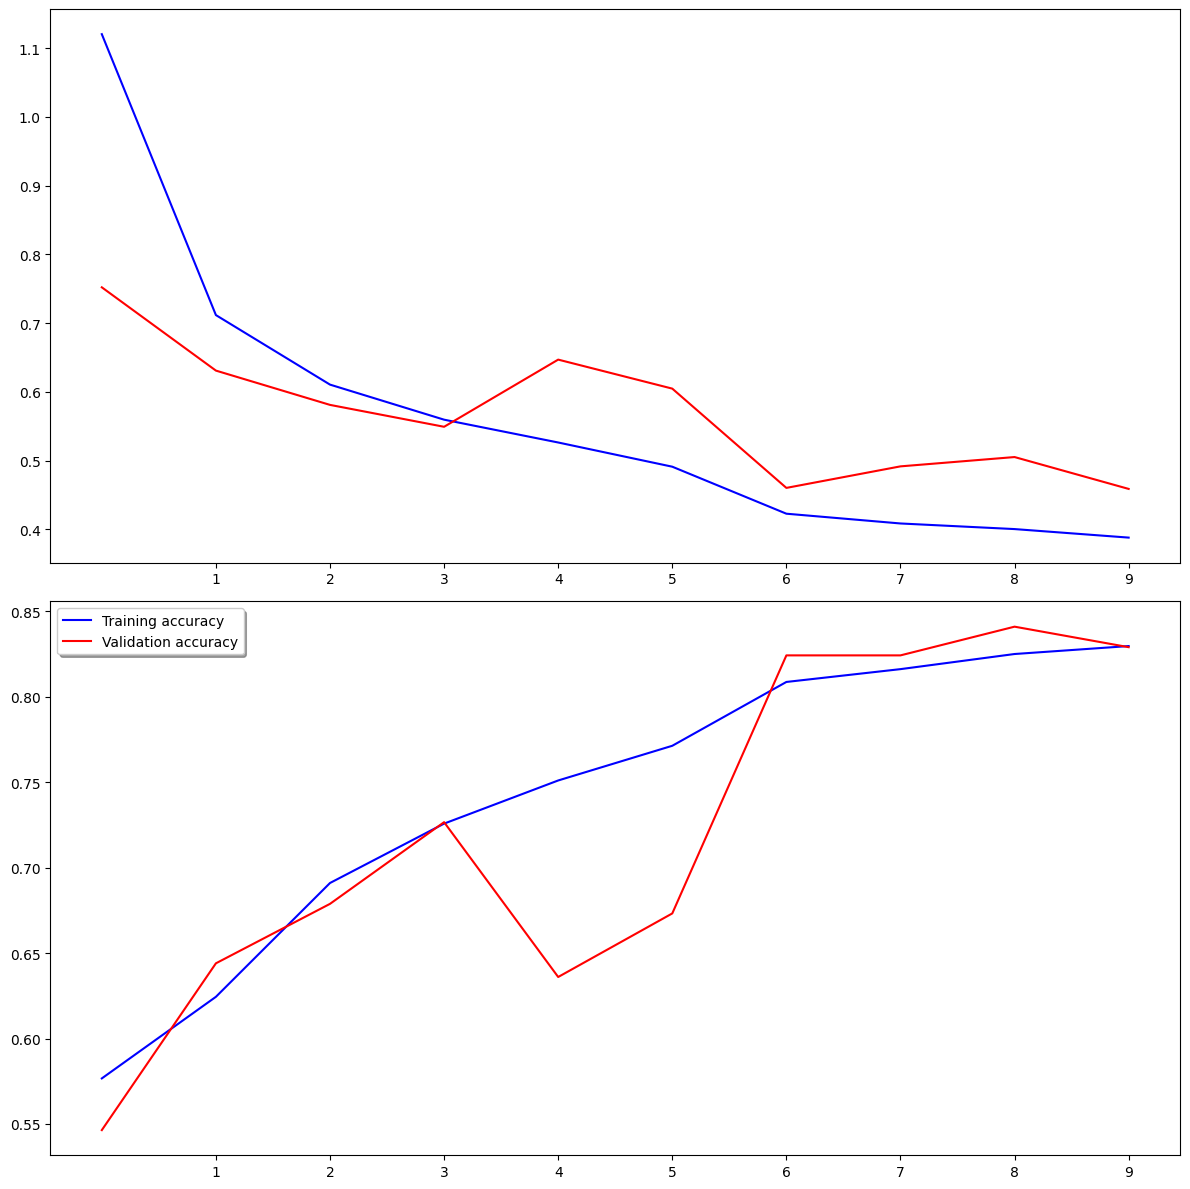

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(train.history['loss'], color='b', label="Training loss")
ax1.plot(train.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))

ax2.plot(train.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(train.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [17]:
!wget https://storage.googleapis.com/srh-dataset/animal-classification/animal-test.zip
!unzip animal-test.zip -d test

--2023-05-24 10:18:28--  https://storage.googleapis.com/srh-dataset/animal-classification/animal-test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65357 (64K) [application/zip]
Saving to: ‘animal-test.zip’

animal-test.zip     100%[===================>]  63.83K   166KB/s    in 0.4s    

2023-05-24 10:18:30 (166 KB/s) - ‘animal-test.zip’ saved [65357/65357]

Archive:  animal-test.zip
  inflating: test/cat1.jpg           
  inflating: test/cat2.jpg           
  inflating: test/cat3.jpg           
  inflating: test/dog1.jpg           
  inflating: test/dog2.jpg           
  inflating: test/dog3.jpg           
  inflating: test/dog4.jpg           


1/1 [==============================] - 0s 29ms/step


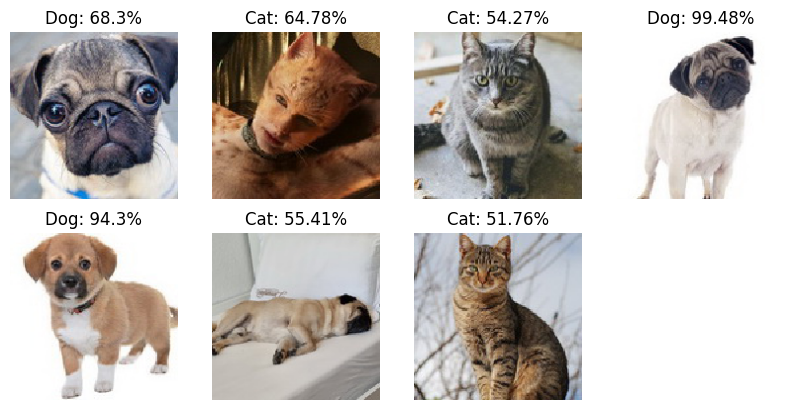

In [20]:
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.figure(figsize=(10, 10))
for i, file in enumerate(glob.glob('test/*')): 
    img = load_img(file, target_size=IMAGE_SIZE)

    # convert to array
    img = img_to_array(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype("uint8"))

    # reshape into a single sample with 3 channels
    img = img.reshape(1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    predict = model.predict(img)
    percent = predict[0][0]*100

    result = 'Cat'
    if percent < 50:
        result = 'Dog'
        percent = 100 - percent

    plt.title(result + ": " + str(round(percent, 2)) + "%")
    plt.axis("off")